# Introduction

This notebook demonstrates the creation of a basic machine learning model using graph embeddings.  For simplicity, we will be using the [Fast Random Projection](https://neo4j.com/docs/graph-data-science/current/algorithms/fastrp/) embedding algorithm to create our graph embeddings.  This algorithm was chosen for its simplicity, speed, and for demonstration purposes, however there are other, more sophisticated methods for creating embeddings that you are encouraged to explore beyond this course.  You can get more detailed information on the hyperparameters and what they mean in [this blog post](https://dev.neo4j.com/fastrp_background). 

Like in the previous example, we will be pulling our embeddings into this notebook and conducting minor data type conversions.  However, unlike the previous notebook, we have the opportunity to tinker with the hyperparameters of FastRP and explore their impacts on the overall results.  Once we have calculated the graph embeddings, we will put them into a traditional support vector classifier and evaluate the model's accuracy.  Lastly, this notebook shows a quick 2-D visualization of the embeddings based on category via t-SNE dimensionality reduction. 

_It is necessary to have the database populated prior to running this notebook._

### Note: This next line is required if you are running this notebook on Google Colab.

In [1]:
!pip install neo4j

     |████████████████████████████████| 76 kB 4.1 MB/s 
  Created wheel for neo4j: filename=neo4j-4.3.7-py3-none-any.whl size=100642 sha256=baa1b6aa4e248682fbb360226dea0d55aee71ac6d3debdfd9c420b761598f63b
  Stored in directory: /root/.cache/pip/wheels/b5/24/bb/cece9fcfdd5e1aa0683e2533945e1e3f27f70f342ff7e28993
Successfully built neo4j


In [2]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pprint

In [3]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [4]:
uri = ''
pwd = ''

conn = Neo4jConnection(uri=uri, user="neo4j", pwd=pwd)

conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=2708>]

In [5]:
def create_embs(dim=10):

    query = """CALL gds.fastRP.write(
               'cora',
               {
                   embeddingDimension: %d,
                   iterationWeights: [0.0, 0.0, 1.0, 1.0],
                   writeProperty: 'fastrp_embedding'
               }
           )
    """ % (dim)

    conn.query(query)
    return

def create_X_y():

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.fastrp_embedding AS fastrp_embedding"""
    emb_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    emb_df['target'] = pd.factorize(emb_df['subject'])[0].astype("float32")
    y = emb_df['target'].to_numpy()
    emb_df['X'] = emb_df['fastrp_embedding'].apply(lambda x: np.array(x))
    X = np.array(emb_df['X'].to_list())

    return X, y

In [8]:
def modeler(dim, k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    create_embs(dim=dim)
    X, y = create_X_y()

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

Accuracy scores:  [0.8286558345642541, 0.8330871491875923, 0.8552437223042836, 0.8360413589364845, 0.8375184638109305]
Mean accuracy:  0.8381093057607091


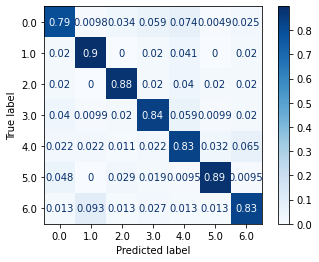

In [9]:
modeler(dim=256)

In [33]:
def create_tsne_plot(dim, emb_name='fastrp_embedding'):

    create_embs(dim=dim)
    X, y = create_X_y()

    X_emb = TSNE(n_components=2).fit_transform(X)

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': y
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show
    
    return tsne_df

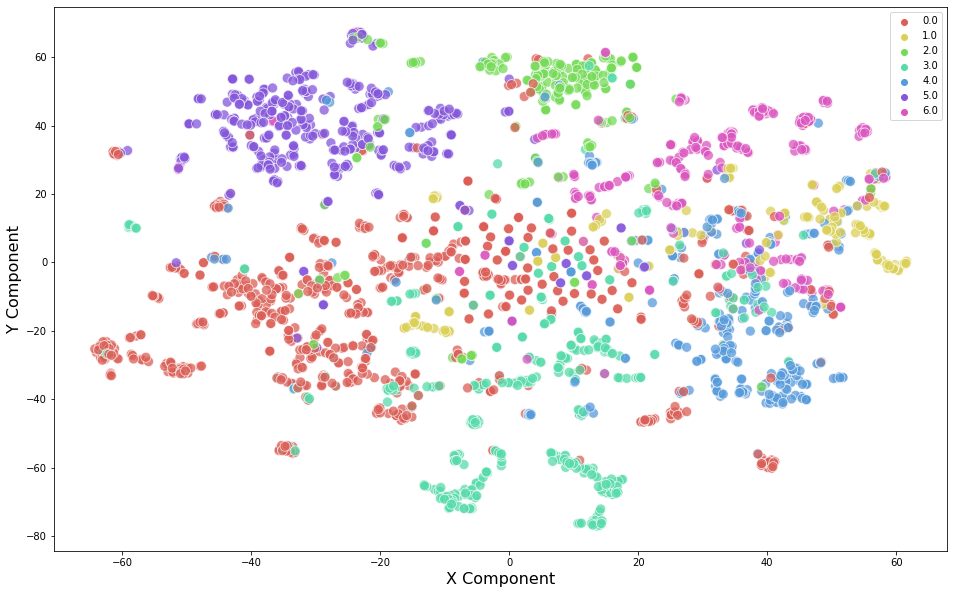

In [34]:
tsne_df = create_tsne_plot(dim=256)